<a href="https://colab.research.google.com/github/giedriusblazys/SDA_DS_class/blob/main/practice/03_05_Telecom_Churn_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification with Imbalanced Data

## setup

In [1]:
import pandas as pd
import numpy as np # linear algebra
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

# sns.set()

In [2]:
from sklearn.metrics import accuracy_score, precision_recall_curve, average_precision_score, auc, roc_curve
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, SCORERS
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, LeaveOneOut

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import preprocessing

import graphviz

from sklearn.utils import resample

## Custom functions

In [3]:
def score_prediction(y_test, y_pred):
    print(f'Accuracy:  {accuracy_score(y_test, y_pred):.3f}')
    print(f'Precision: {precision_score(y_test, y_pred):.3f}')
    print(f'Recall:    {recall_score(y_test, y_pred):.3f}')
    print(f'F1:        {f1_score(y_test, y_pred):.3f}')
    
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

In [4]:
def heatmap(x, y, **kwargs):
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 # Use 256 colors for the diverging color palette
        palette = sns.color_palette("Blues", n_colors) 

    if 'color_range' in kwargs:
        color_min, color_max = kwargs['color_range']
    else:
        color_min, color_max = min(color), max(color) # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val):
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale
    if 'x_order' in kwargs: 
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in sorted(set([v for v in x]))]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs: 
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in sorted(set([v for v in y]))]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}

    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x10 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the left 14/15ths of the grid for the main plot

    marker = kwargs.get('marker', 's')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', 'marker', 'x_order', 'y_order'
    ]}

    ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size], 
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
    ax.set_xticks([v for k,v in x_to_num.items()])
    ax.set_xticklabels([k for k in x_to_num], rotation=45, horizontalalignment='right')
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num])

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor('#F1F1F1')

    # Add color legend on the right side of the plot
    if color_min < color_max:
        ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

        col_x = [0]*len(palette) # Fixed x coordinate for the bars
        bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

        bar_height = bar_y[1] - bar_y[0]
        ax.barh(
            y=bar_y,
            width=[5]*len(palette), # Make bars 5 units wide
            left=col_x, # Make bars start at 0
            height=bar_height,
            color=palette,
            linewidth=0
        )
        ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
        ax.grid(False) # Hide grid
        ax.set_facecolor('white') # Make background white
        ax.set_xticks([]) # Remove horizontal ticks
        ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
        ax.yaxis.tick_right() # Show vertical ticks on the right 


def corrplot(data, size_scale=500, marker='s'):
    corr = pd.melt(data.reset_index(), id_vars='index')
    corr.columns = ['x', 'y', 'value']
    heatmap(
        corr['x'], corr['y'],
        color=corr['value'], color_range=[-1, 1],
        palette=sns.diverging_palette(20, 220, n=256),
        size=corr['value'].abs(), size_range=[0,1],
        marker=marker,
        x_order=data.columns,
        y_order=data.columns[::-1],
        size_scale=size_scale
    )

In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Orange Telecom's Churn

The Orange Telecom's Churn Dataset, which consists of cleaned customer activity data (features), along with a churn label specifying whether a customer canceled the subscription, will be used to develop predictive models. Two datasets are made available here: The churn-80 and churn-20 datasets can be downloaded.

The two sets are from the same batch, but have been split by an 80/20 ratio. As more data is often desirable for developing ML models, let's use the larger set (that is, churn-80) for training and cross-validation purposes, and the smaller set (that is, churn-20) for final testing and model performance evaluation.

https://www.kaggle.com/mnassrib/telecom-churn-datasets

In [6]:
df = pd.read_csv("https://github.com/giedriusblazys/SDA_DS_class/raw/main/practice/input/churn-bigml-80.csv")
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   2666 non-null   object 
 1   Account length          2666 non-null   int64  
 2   Area code               2666 non-null   int64  
 3   International plan      2666 non-null   object 
 4   Voice mail plan         2666 non-null   object 
 5   Number vmail messages   2666 non-null   int64  
 6   Total day minutes       2666 non-null   float64
 7   Total day calls         2666 non-null   int64  
 8   Total day charge        2666 non-null   float64
 9   Total eve minutes       2666 non-null   float64
 10  Total eve calls         2666 non-null   int64  
 11  Total eve charge        2666 non-null   float64
 12  Total night minutes     2666 non-null   float64
 13  Total night calls       2666 non-null   int64  
 14  Total night charge      2666 non-null   

In [8]:
def corr_plot(df):
    corr = df.corr()
    plt.figure(figsize=(10, 10))
    ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
    )
    ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
    )

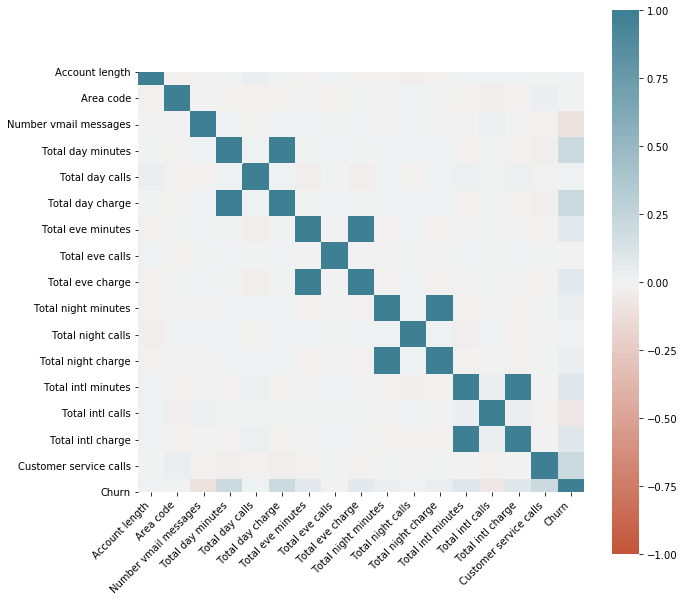

In [9]:
corr_plot(df)

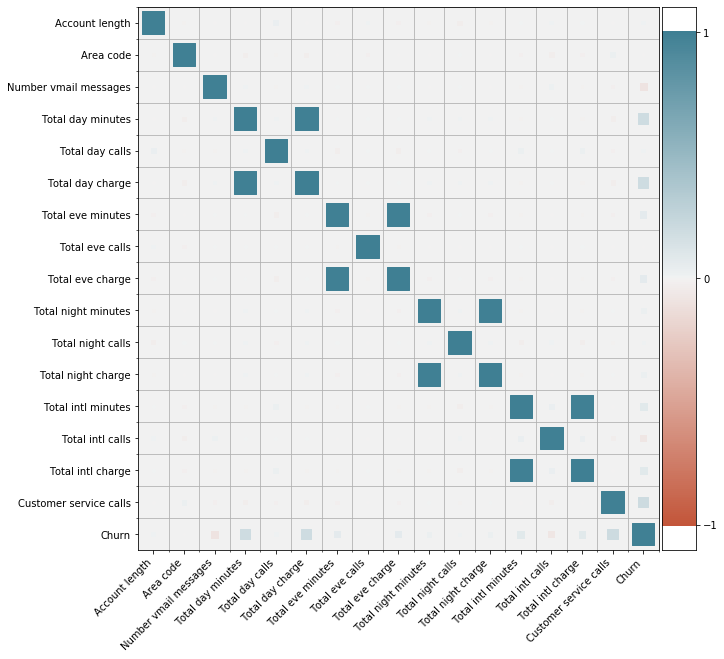

In [10]:
corr = df.corr()
plt.figure(figsize=(10, 10))
corrplot(corr)

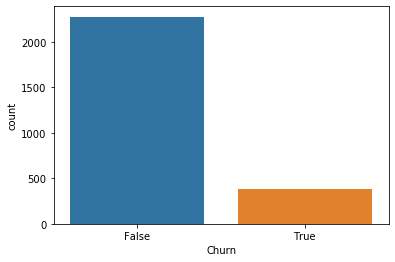

In [11]:
sns.countplot(x=df["Churn"]);

In [12]:
df.columns

Index(['State', 'Account length', 'Area code', 'International plan',
       'Voice mail plan', 'Number vmail messages', 'Total day minutes',
       'Total day calls', 'Total day charge', 'Total eve minutes',
       'Total eve calls', 'Total eve charge', 'Total night minutes',
       'Total night calls', 'Total night charge', 'Total intl minutes',
       'Total intl calls', 'Total intl charge', 'Customer service calls',
       'Churn'],
      dtype='object')

In [13]:
#spliting the data for target and features
X = df.drop(columns='Churn', axis=1)
X = X.drop(columns=['Area code', 'State', 'Total day calls', 'Total eve calls', 'Total night calls'], axis=1)
y = df['Churn'].astype('int')

#creating the test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42, stratify=y)
print(f'X_train: {X_train.shape}, X_test{X_test.shape}')

## One-hot encoder

s = (X_train.dtypes == 'object')
obj_cols = list(s[s].index)

OH_encoder = preprocessing.OneHotEncoder(drop='first', handle_unknown='ignore')

X_train_array = OH_encoder.fit_transform(X_train[obj_cols]).toarray()
OH_cols_train = pd.DataFrame(X_train_array, columns = OH_encoder.get_feature_names_out())

X_test_array = OH_encoder.transform(X_test[obj_cols]).toarray()
OH_cols_test = pd.DataFrame(X_test_array, columns = OH_encoder.get_feature_names_out())
OH_cols_train.index = X_train.index
OH_cols_test.index = X_test.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(obj_cols, axis=1)
num_X_test = X_test.drop(obj_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_test = pd.concat([num_X_test, OH_cols_test], axis=1)
# OH_X_train.columns

X_train: (1866, 14), X_test(800, 14)


## Questions:

1. Use the following Algorithms to estimate Churn model with defaul parameters:

```
sklearn.neighbors.KNeighborsClassifier, sklearn.svm.SVC, 
sklearn.linear_model.LogisticRegression, sklearn.tree.DecisionTreeClassifier
```

2. Report and compare `F1-score`

For next time:

3. Try different hyper-parameters (
    
    SVM: kelnel, C,

    KNN: n_neighbors, p, weights)

4. Start reading about GridSearchCV, RandomSearchCV

In [14]:
print(OH_X_train.shape, OH_X_test.shape, y_train.shape, y_test.shape)

(1866, 14) (800, 14) (1866,) (800,)


In [15]:
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

In [16]:
df_results = pd.DataFrame(columns = ['method', 'parameters', 'f1-score'])

In [17]:
# svm_model = SVC(kernel='linear', C=10, random_state=42).fit(OH_X_train, y_train)
# y_pred = svm_model.predict(OH_X_test)
# print(f'SVM F1 (no normalization): {f1_score(y_true=y_test, y_pred=y_pred)}')

In [18]:
min_max_scaler = MinMaxScaler()

X_train_minmax = min_max_scaler.fit_transform(OH_X_train)
X_test_minmax = min_max_scaler.transform(OH_X_test)

In [19]:
svm_model = SVC(kernel='linear', C=10, random_state=42).fit(X_train_minmax, y_train)
y_pred = svm_model.predict(X_test_minmax)
print(f'SVM F1 (data normalized): {f1_score(y_true=y_test, y_pred=y_pred)}')
# df_results.loc[len(df_results)] = ['SVM', 'kernel=linear', f1_score(y_true=y_test, y_pred=y_pred)]

SVM F1 (data normalized): 0.0


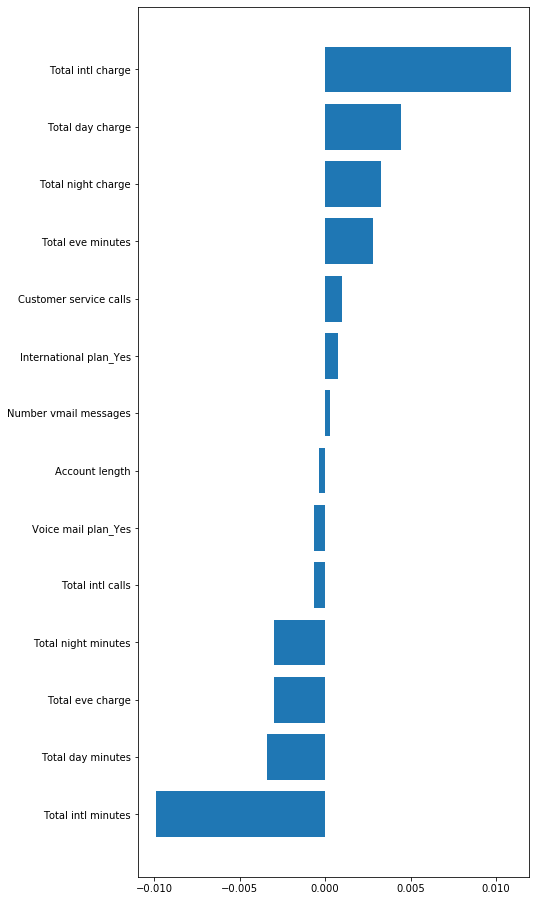

In [20]:
features_names = OH_X_train.columns

plt.figure(figsize=(7, 16))
f_importances(svm_model.coef_[0], features_names)

In [21]:
knn_model = KNeighborsClassifier().fit(OH_X_train, y_train)
y_pred = knn_model.predict(OH_X_test)
print(f'KNN F1 (no normalization): {f1_score(y_true=y_test, y_pred=y_pred)}')
df_results.loc[len(df_results)] = ['KNN', 'no normalization', f1_score(y_true=y_test, y_pred=y_pred)]

KNN F1 (no normalization): 0.41916167664670656


In [22]:
knn_model = KNeighborsClassifier().fit(X_train_minmax, y_train)
y_pred = knn_model.predict(X_test_minmax)
print(f'KNN F1 (data normalized): {f1_score(y_true=y_test, y_pred=y_pred)}')

KNN F1 (data normalized): 0.5054945054945056


In [23]:
logit_model = LogisticRegression(penalty='l2', C=1.5, max_iter=10000).fit(OH_X_train, y_train)
y_pred = logit_model.predict(OH_X_test)
print(f'logistic F1 (no normalization): {f1_score(y_true=y_test, y_pred=y_pred)}')

logistic F1 (no normalization): 0.29411764705882354


In [24]:
logit_model = LogisticRegression(penalty='l2', C=1).fit(X_train_minmax, y_train)
y_pred = logit_model.predict(X_test_minmax)
print(f'logistic F1 (data normalized): {f1_score(y_true=y_test, y_pred=y_pred)}')

logistic F1 (data normalized): 0.23076923076923075


## GridSearchCV, RandomSearchCV

https://scikit-learn.org/stable/modules/grid_search.html

In [25]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, randint

def plot_classification(y_true, y_pred):
    target_names = ['Loyal', 'Leavers']
    labels_names = [0, 1] 
    print(classification_report(y_true, y_pred,labels=labels_names, target_names=target_names))    
    cm = confusion_matrix(y_true, y_pred,labels=labels_names)  #, normalize='true'
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
    disp = disp.plot(cmap=plt.cm.Blues,values_format='g')
    plt.show()
    



In [26]:
# 16 combinations
score = "f1"
knn_model = KNeighborsClassifier()

### Grid Search - 16 combinations

In [27]:
%%time
tuned_parameters = {"n_neighbors": [1, 3, 5, 7], "weights": ["uniform", "distance"], "p": [2, 10] }

clf_grid = GridSearchCV(knn_model, tuned_parameters, scoring=score)
clf_grid.fit(X_train_minmax, y_train)

y_pred = clf_grid.predict(X_test_minmax)
print(f'Grid Search F1: {f1_score(y_true=y_test, y_pred=y_pred)}')

print("Best parameters set found on training set:")
print(clf_grid.best_params_)

Grid Search F1: 0.5353535353535354
Best parameters set found on training set:
{'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
CPU times: user 4.11 s, sys: 181 ms, total: 4.29 s
Wall time: 3.62 s


### Random Search - 16 combinations

In [28]:
%%time
tuned_parameters_rs = {"n_neighbors": randint(1, 10), "weights": ["uniform", "distance"], "p": randint(1, 100) }
clf_rs = RandomizedSearchCV(knn_model, tuned_parameters_rs, scoring=score, n_iter=16)
clf_rs.fit(X_train_minmax, y_train)
y_pred = clf_rs.predict(X_test_minmax)
print(f'Random Search F1: {f1_score(y_true=y_test, y_pred=y_pred)}')
print("Best parameters set found on training set:")
print(clf_rs.best_params_)

Random Search F1: 0.5408163265306122
Best parameters set found on training set:
{'n_neighbors': 3, 'p': 3, 'weights': 'distance'}
CPU times: user 5.85 s, sys: 96.3 ms, total: 5.94 s
Wall time: 5.96 s


In [29]:
%%time
tuned_parameters_rs = {"n_neighbors": randint(1, 5), "weights": ["uniform", "distance"], "p": randint(1, 10) }
clf_rs = RandomizedSearchCV(knn_model, tuned_parameters_rs, scoring=score, n_iter=16)
clf_rs.fit(X_train_minmax, y_train)
y_pred = clf_rs.predict(X_test_minmax)
print(f'Random Search F1: {f1_score(y_true=y_test, y_pred=y_pred)}')
print("Best parameters set found on training set:")
print(clf_rs.best_params_)

Random Search F1: 0.5353535353535354
Best parameters set found on training set:
{'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
CPU times: user 4.49 s, sys: 70.9 ms, total: 4.56 s
Wall time: 4.58 s


#### Questions for practices
- test out Grid and Random search algorithms to find best parameters for SVM classifier
- 'linear' kernel: C
- 'rbf' kernel: C, gamma
- be mindful about estimation time
- for random search use uniform distribution when possible {"C": uniform(0.1, 1000)}

In [30]:
svm_params = {'C': 21.281798726506207, 'gamma': 0.522614759878134, 'kernel': 'rbf'}

In [31]:
svm_model = SVC(**svm_params).fit(X_train_minmax, y_train)
y_pred = svm_model.predict(X_test_minmax)
print(f'Best SVM F1: {f1_score(y_true=y_test, y_pred=y_pred)}')

Best SVM F1: 0.6217616580310881


              precision    recall  f1-score   support

       Loyal       0.92      0.98      0.95       684
     Leavers       0.78      0.52      0.62       116

    accuracy                           0.91       800
   macro avg       0.85      0.75      0.78       800
weighted avg       0.90      0.91      0.90       800



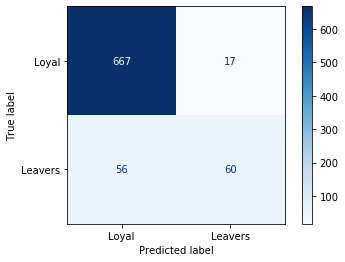

In [32]:
plot_classification(y_test, y_pred)

In [33]:
# features_names = OH_X_train.columns
# f_importances(svm_model.coef_, features_names)

In [34]:
# # The SHAP values
# import shap

# svm_explainer = shap.KernelExplainer(svm_model.predict, X_test_minmax)
# svm_shap_values = svm_explainer.shap_values(X_test_minmax)

# # Make plot
# shap.summary_plot(shap_values, X_test, plot_size=[16,12])

In [35]:
from collections import Counter

# Different ways to upsample
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN

In [36]:
counter_before = Counter(y_train)

smt = SMOTE(random_state=42)
X_train_sm, y_train_sm = smt.fit_resample(X_train_minmax, y_train)

print(f'Before: {counter_before}')
print(f'After: {Counter(y_train_sm)}')

Before: Counter({0: 1594, 1: 272})
After: Counter({0: 1594, 1: 1594})


In [37]:
svm_model_sm = SVC(**svm_params).fit(X_train_sm, y_train_sm)
y_pred = svm_model_sm.predict(X_test_minmax)
print(f'Best SVM F1: {f1_score(y_true=y_test, y_pred=y_pred)}')

Best SVM F1: 0.6477732793522267


              precision    recall  f1-score   support

       Loyal       0.95      0.93      0.94       684
     Leavers       0.61      0.69      0.65       116

    accuracy                           0.89       800
   macro avg       0.78      0.81      0.79       800
weighted avg       0.90      0.89      0.89       800



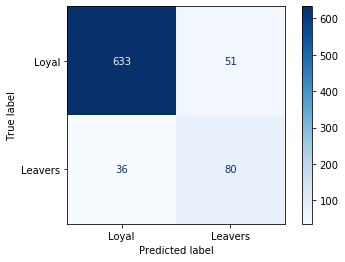

In [38]:
plot_classification(y_test, y_pred)

In [39]:
%%time
tuned_parameters = {'C': [1, 21, 100], 'gamma': [0.1, 0.52], 'kernel': ['rbf']}
svm_model = SVC()
score = 'f1'

clf_grid = GridSearchCV(svm_model, tuned_parameters, scoring=score)
clf_grid.fit(X_train_sm, y_train_sm)

y_pred = clf_grid.predict(X_test_minmax)
print(f'Grid Search F1: {f1_score(y_true=y_test, y_pred=y_pred)}')

print("Best parameters set found on training set:")
print(clf_grid.best_params_)

Grid Search F1: 0.6448979591836733
Best parameters set found on training set:
{'C': 100, 'gamma': 0.52, 'kernel': 'rbf'}
CPU times: user 7.67 s, sys: 127 ms, total: 7.79 s
Wall time: 7.83 s


              precision    recall  f1-score   support

       Loyal       0.94      0.93      0.94       684
     Leavers       0.61      0.68      0.64       116

    accuracy                           0.89       800
   macro avg       0.78      0.80      0.79       800
weighted avg       0.90      0.89      0.89       800



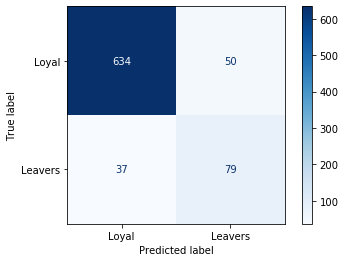

In [40]:
plot_classification(y_test, y_pred)

In [41]:
smt = SMOTETomek(random_state=42)
X_train_sm, y_train_sm = smt.fit_resample(X_train_minmax, y_train)

print(f'Before: {counter_before}')
print(f'After: {Counter(y_train_sm)}')

Before: Counter({0: 1594, 1: 272})
After: Counter({0: 1585, 1: 1585})


In [42]:
svm_model_sm = SVC(**svm_params).fit(X_train_sm, y_train_sm)
y_pred = svm_model_sm.predict(X_test_minmax)
print(f'Best SVM F1: {f1_score(y_true=y_test, y_pred=y_pred)}')

Best SVM F1: 0.6477732793522267


In [43]:
smt = SMOTEENN(random_state=42)
X_train_sm, y_train_sm = smt.fit_resample(X_train_minmax, y_train)

print(f'Before: {counter_before}')
print(f'After: {Counter(y_train_sm)}')
svm_model_sm = SVC(**svm_params).fit(X_train_sm, y_train_sm)
y_pred = svm_model_sm.predict(X_test_minmax)
print(f'Best SVM F1: {f1_score(y_true=y_test, y_pred=y_pred)}')

Before: Counter({0: 1594, 1: 272})
After: Counter({1: 1532, 0: 1209})
Best SVM F1: 0.5742574257425742


In [44]:
%%time
tuned_parameters = {'C': [1, 15, 21, 30], 'gamma': [0.1, 0.52], 'kernel': ['rbf']}
svm_model = SVC()
score = 'f1'

clf_grid = GridSearchCV(svm_model, tuned_parameters, scoring=score)
clf_grid.fit(X_train_sm, y_train_sm)

y_pred = clf_grid.predict(X_test_minmax)
print(f'Grid Search F1: {f1_score(y_true=y_test, y_pred=y_pred)}')

print("Best parameters set found on training set:")
print(clf_grid.best_params_)

Grid Search F1: 0.5819397993311037
Best parameters set found on training set:
{'C': 30, 'gamma': 0.52, 'kernel': 'rbf'}
CPU times: user 5.57 s, sys: 82.3 ms, total: 5.65 s
Wall time: 5.67 s


## Naive Bayes Classifier

In [45]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB

Naive Bayes F1 (data normalized): 0.49579831932773105

              precision    recall  f1-score   support

       Loyal       0.92      0.91      0.91       684
     Leavers       0.48      0.51      0.50       116

    accuracy                           0.85       800
   macro avg       0.70      0.71      0.70       800
weighted avg       0.85      0.85      0.85       800



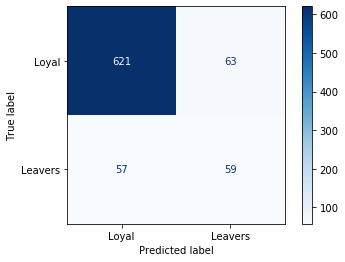

In [46]:
clf = GaussianNB()
nb_model = clf.fit(X_train_minmax, y_train)
y_pred = nb_model.predict(X_test_minmax)
print(f'Naive Bayes F1 (data normalized): {f1_score(y_true=y_test, y_pred=y_pred)}')
print()
plot_classification(y_test, y_pred)

In [47]:
%%time
tuned_parameters =  {'var_smoothing': np.logspace(0,-9, num=30)}
clf = GaussianNB()
score = 'f1'

clf_grid = GridSearchCV(clf, tuned_parameters, scoring=score)
clf_grid.fit(X_train_minmax, y_train)

y_pred = clf_grid.predict(X_test_minmax)
print(f'Grid Search F1: {f1_score(y_true=y_test, y_pred=y_pred)}')
print()
print("Best parameters set found on training set:")
print(clf_grid.best_params_)

Grid Search F1: 0.49579831932773105

Best parameters set found on training set:
{'var_smoothing': 0.00038566204211634724}
CPU times: user 417 ms, sys: 15.1 ms, total: 433 ms
Wall time: 434 ms



              precision    recall  f1-score   support

       Loyal       0.92      0.91      0.91       684
     Leavers       0.48      0.51      0.50       116

    accuracy                           0.85       800
   macro avg       0.70      0.71      0.70       800
weighted avg       0.85      0.85      0.85       800



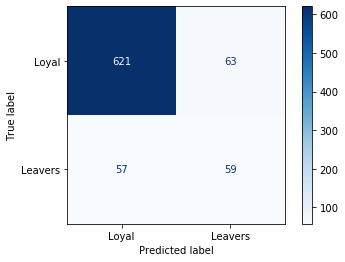

In [48]:
print()
plot_classification(y_test, y_pred)

#### Try Naive Bayes Classifier on upsampled data

In [49]:
smt = SMOTEENN(random_state=42)
X_train_sm, y_train_sm = smt.fit_resample(X_train_minmax, y_train)

print(f'Before: {counter_before}')
print(f'After: {Counter(y_train_sm)}')

Before: Counter({0: 1594, 1: 272})
After: Counter({1: 1532, 0: 1209})


In [50]:
%%time
tuned_parameters =  {'var_smoothing': np.logspace(0,-9, num=40)}
clf = GaussianNB()
score = 'f1'

clf_grid = GridSearchCV(clf, tuned_parameters, scoring=score)
clf_grid.fit(X_train_sm, y_train_sm)

y_pred = clf_grid.predict(X_test_minmax)
print(f'Grid Search F1: {f1_score(y_true=y_test, y_pred=y_pred)}')
print()
print("Best parameters set found on training set:")
print(clf_grid.best_params_)

Grid Search F1: 0.5269461077844312

Best parameters set found on training set:
{'var_smoothing': 0.0002030917620904735}
CPU times: user 544 ms, sys: 26 ms, total: 570 ms
Wall time: 572 ms



              precision    recall  f1-score   support

       Loyal       0.95      0.81      0.88       684
     Leavers       0.40      0.76      0.53       116

    accuracy                           0.80       800
   macro avg       0.68      0.78      0.70       800
weighted avg       0.87      0.80      0.82       800



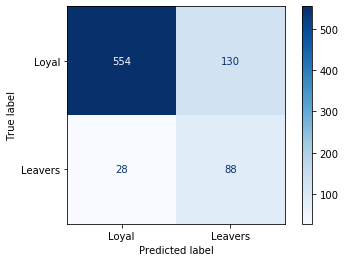

In [51]:
print()
plot_classification(y_test, y_pred)

In [52]:
from sklearn.linear_model import LogisticRegression

Grid Search F1: 0.23076923076923075

              precision    recall  f1-score   support

       Loyal       0.87      0.97      0.92       684
     Leavers       0.45      0.16      0.23       116

    accuracy                           0.85       800
   macro avg       0.66      0.56      0.57       800
weighted avg       0.81      0.85      0.82       800



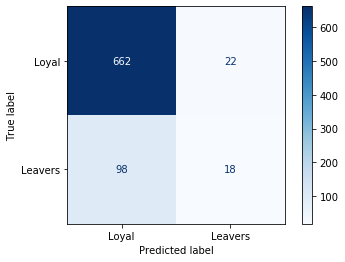

In [53]:
logit_model = LogisticRegression().fit(X_train_minmax, y_train)

y_pred = logit_model.predict(X_test_minmax)

print(f'Grid Search F1: {f1_score(y_true=y_test, y_pred=y_pred)}')
print()
plot_classification(y_test, y_pred)

F1: 0.43934426229508194

              precision    recall  f1-score   support

       Loyal       0.92      0.82      0.87       684
     Leavers       0.35      0.58      0.44       116

    accuracy                           0.79       800
   macro avg       0.64      0.70      0.65       800
weighted avg       0.84      0.79      0.81       800



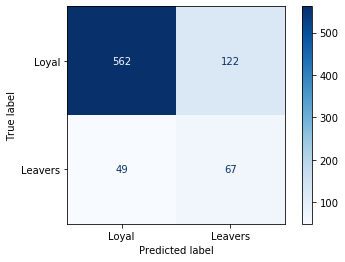

In [54]:
logit_model = LogisticRegression().fit(X_train_sm, y_train_sm)
thresh = 0.7
y_pred_prob = logit_model.predict_proba(X_test_minmax)
y_pred = (y_pred_prob[:,1] > thresh).astype('int')

print(f'F1: {f1_score(y_true=y_test, y_pred=y_pred)}')
print()
plot_classification(y_test, y_pred)

In [55]:
# beta = 2, gives more weight to recall
fbeta_score(y_true=y_test, y_pred=y_pred, beta=2)

0.5130168453292495

## Classifiers Ensemble

What if we combine not so good classifiers? Can we improve accuracy

### Random Forrest

In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer

#### Upsampled data

Let's implements F2 score (more weight to precision than F1)

In [67]:
f2_scorer = make_scorer(fbeta_score, beta=2)

clf = RandomForestClassifier(random_state=42)

In [70]:
%%time
tuned_parameters = {'n_estimators': [30, 50, 100],
               'max_features': ['auto'],
               'min_samples_split': [3, 4, 5, 7],
               'bootstrap': [False],
                }


clf_grid = GridSearchCV(clf, tuned_parameters, scoring=f2_scorer, n_jobs=-1)
clf_grid.fit(X_train_sm, y_train_sm)
rf_params = clf_grid.best_params_

y_pred = clf_grid.predict(X_test_minmax)
print(f'Grid Search F2: {fbeta_score(y_true=y_test, y_pred=y_pred, beta=2)}')

print("Best parameters set found on training set:")
print(clf_grid.best_params_)

Grid Search F2: 0.7004830917874397
Best parameters set found on training set:
{'bootstrap': False, 'max_features': 'auto', 'min_samples_split': 4, 'n_estimators': 50}
CPU times: user 340 ms, sys: 16.8 ms, total: 357 ms
Wall time: 2.14 s


In [71]:
clf = RandomForestClassifier(**rf_params, random_state=42)

clf.fit(X_train_sm, y_train_sm)

y_pred = clf.predict(X_test_minmax)
print(f'F2: {fbeta_score(y_true=y_test, y_pred=y_pred, beta=2):.2f}')

F2: 0.70


              precision    recall  f1-score   support

       Loyal       0.95      0.90      0.93       684
     Leavers       0.55      0.75      0.64       116

    accuracy                           0.88       800
   macro avg       0.75      0.82      0.78       800
weighted avg       0.90      0.88      0.88       800



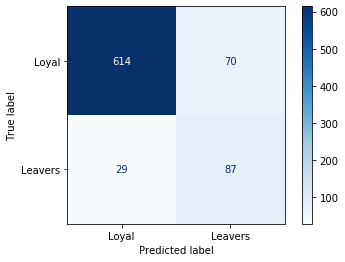

In [60]:
plot_classification(y_test, y_pred)

#### Original data

Let's implements F2 score (more weight to precision than F1)

In [61]:
f2_scorer = make_scorer(fbeta_score, beta=2)

clf = RandomForestClassifier(random_state=42)

In [62]:
%%time
tuned_parameters = {'n_estimators': [50, 70, 100],
               'max_features': ['auto'],
               'min_samples_split': [4, 5, 7],
               'bootstrap': [False]}


clf_grid = GridSearchCV(clf, tuned_parameters, scoring=f2_scorer)
clf_grid.fit(X_train_minmax, y_train)
rf_params = clf_grid.best_params_

y_pred = clf_grid.predict(X_test_minmax)
print(f'Grid Search F2: {fbeta_score(y_true=y_test, y_pred=y_pred, beta=2)}')

print("Best parameters set found on training set:")
print(clf_grid.best_params_)

Grid Search F2: 0.759493670886076
Best parameters set found on training set:
{'bootstrap': False, 'max_features': 'auto', 'min_samples_split': 4, 'n_estimators': 100}
CPU times: user 11 s, sys: 182 ms, total: 11.2 s
Wall time: 11.3 s


In [63]:
clf = RandomForestClassifier(**rf_params, random_state=42)

clf.fit(X_train_minmax, y_train)

y_pred = clf.predict(X_test_minmax)
print(f'F2: {fbeta_score(y_true=y_test, y_pred=y_pred, beta=2):.2f}')

F2: 0.76


              precision    recall  f1-score   support

       Loyal       0.95      0.99      0.97       684
     Leavers       0.94      0.72      0.82       116

    accuracy                           0.95       800
   macro avg       0.95      0.86      0.90       800
weighted avg       0.95      0.95      0.95       800



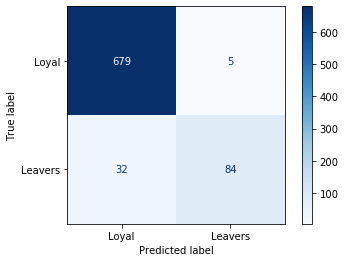

In [64]:
plot_classification(y_test, y_pred)

In [81]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

In [74]:
%%time

clf = AdaBoostClassifier(random_state=42)

tuned_parameters = {'n_estimators': [10, 30, 50, 100]}

clf_grid = GridSearchCV(clf, tuned_parameters, scoring=f2_scorer)
clf_grid.fit(X_train_minmax, y_train)
rf_params = clf_grid.best_params_

y_pred = clf_grid.predict(X_test_minmax)
print(f'Grid Search F2: {fbeta_score(y_true=y_test, y_pred=y_pred, beta=2)}')

print("Best parameters set found on training set:")
print(clf_grid.best_params_)

Grid Search F2: 0.488245931283906
Best parameters set found on training set:
{'n_estimators': 100}
CPU times: user 2.69 s, sys: 70 ms, total: 2.76 s
Wall time: 2.78 s


Grid Search F2: 0.7857142857142857
Best parameters set found on training set:
{'max_features': 'auto', 'min_samples_split': 5, 'n_estimators': 200}
              precision    recall  f1-score   support

       Loyal       0.96      0.99      0.97       684
     Leavers       0.92      0.76      0.83       116

    accuracy                           0.95       800
   macro avg       0.94      0.87      0.90       800
weighted avg       0.95      0.95      0.95       800



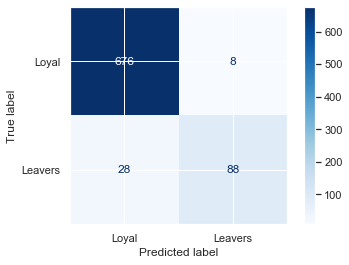

CPU times: user 33 s, sys: 508 ms, total: 33.6 s
Wall time: 33.7 s


In [88]:
%%time
clf = GradientBoostingClassifier(random_state=42)

tuned_parameters = {'n_estimators': [70, 100, 200],
               'max_features': ['auto', 'log2', 'sqrt'],
               'min_samples_split': [5, 7, 10]}

clf_grid = GridSearchCV(clf, tuned_parameters, scoring=f2_scorer) 
clf_grid.fit(X_train_minmax, y_train)
rf_params = clf_grid.best_params_

y_pred = clf_grid.predict(X_test_minmax)

print(f'Grid Search F2: {fbeta_score(y_true=y_test, y_pred=y_pred, beta=2)}')

print("Best parameters set found on training set:")
print(clf_grid.best_params_)

plot_classification(y_test, y_pred)

Grid Search F2: 0.7165861513687601
Best parameters set found on training set:
{'max_features': 'auto', 'min_samples_split': 7, 'n_estimators': 200}
              precision    recall  f1-score   support

       Loyal       0.96      0.90      0.93       684
     Leavers       0.57      0.77      0.65       116

    accuracy                           0.88       800
   macro avg       0.76      0.83      0.79       800
weighted avg       0.90      0.88      0.89       800



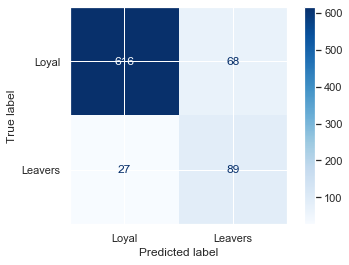

CPU times: user 52.9 s, sys: 814 ms, total: 53.7 s
Wall time: 54 s


In [89]:
%%time
clf = GradientBoostingClassifier(random_state=42)

tuned_parameters = {'n_estimators': [70, 100, 200],
               'max_features': ['auto', 'log2', 'sqrt'],
               'min_samples_split': [5, 7, 10]}

clf_grid = GridSearchCV(clf, tuned_parameters, scoring=f2_scorer) 
clf_grid.fit(X_train_sm, y_train_sm)
rf_params = clf_grid.best_params_

y_pred = clf_grid.predict(X_test_minmax)

print(f'Grid Search F2: {fbeta_score(y_true=y_test, y_pred=y_pred, beta=2)}')

print("Best parameters set found on training set:")
print(clf_grid.best_params_)

plot_classification(y_test, y_pred)